# Plotting synthesized signals

The scope of `pyLeTalker` is to generate a set of signals, most notably the radiated sound pressure signal or acoustic signal in short. Visualization of the synthesized signals must be done through third-party library.

Both [lt.sim()](../api_basic.rst#letalker.sim) and [lt.sim_kinematic()](../api_basic.rst#letalker.sim_kinematic) functions return two objects: `pout` and `res`. The former is a length-`N` vector of the acoustic signal samples at the system sampling rate, which could be found as `lt.fs`. The `N` is the number of samples that you requested when calling [lt.sim()](../api_basic.rst#letalker.sim) or [lt.sim_kinematic()](../api_basic.rst#letalker.sim_kinematic) function. The second output `res` is a dict of simulation results generated by each of 5 elements of the model: `res['lungs']`, `res['trachea']`, `res['vocalfolds']`, `res['vocaltract']`, and `res['lips']`. These `Results` objects host both the element configurations as well as recorded samples of their internal signals.

This example demonstrates how to plot the simulation outcomes using [Matplotlib](https://matplotlib.org/). If you are not familiar with Matplotlib, please follow [their Getting Started Guide](https://matplotlib.org/stable/users/getting_started/) to install the library.

We start out by importing `letalker` and `matplotlib`. We use the shortened prefix (`lt.`) to access `letalker` library.

In [1]:
from matplotlib import pyplot as plt
import letalker as lt

## Plotting acoustic waveform and its spectrum

For the sake of demonstration, let's synthesize /a/ vowel for 100 milliseconds at $f_o =$ 100 Hz (or simulating the first 10 vocal cycles).

In [2]:
T = 0.1 # duration in seconds
N = round(lt.fs*T) # =4410, number of samples to simulate
fo = 100 # fundamental frequency in Hz

pout, res = lt.sim_kinematic(N, fo, "aa")

While we can plot the acoustic signal as a function of sample index, it's more intuitive to have the $x$-axis in seconds. Every `Results` object in the `res` dict contains `ts` item which is the corresponding time vector.

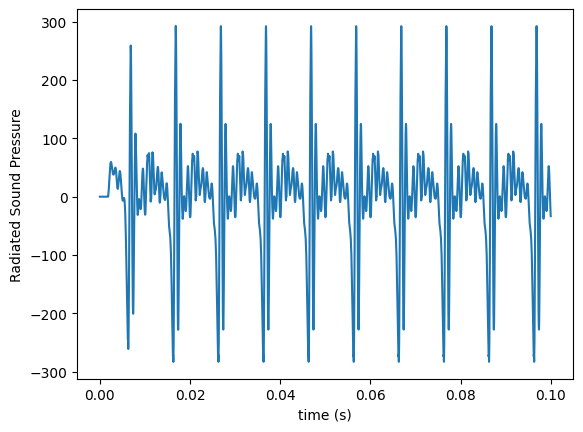

In [3]:
t = res['lips'].ts # grabbing the time vector from lips element

plt.plot(t,pout)
plt.xlabel('time (s)')
plt.ylabel('Radiated Sound Pressure');

To plot the spectrum of the acoustic signal, we use [plt.magnitude_spectrum()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html#matplotlib.pyplot.magnitude_spectrum) function. By default, it shows the frequency content up to the Nyquist frequency (i.e., the half of the sampling rate) which is typically too large to observe human voice behavior. So, we use [plt.xlim()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlim) to only show the frequency content up to 4 kHz (or showing the first 40 harmonics).

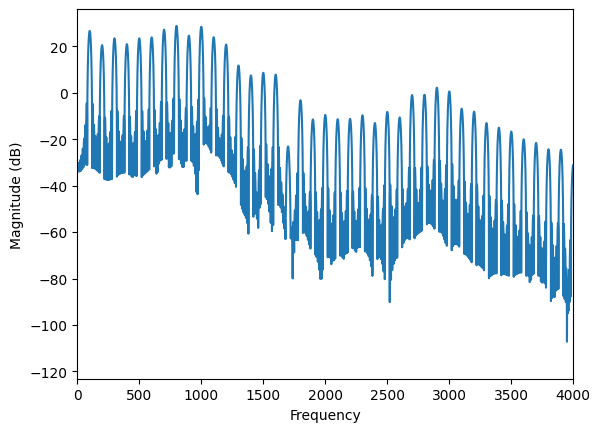

In [4]:
plt.magnitude_spectrum(pout, 
                       Fs=lt.fs,     # sampling rate
                       pad_to=lt.fs, # set the resolution to be 1 Hz
                       scale="dB")   # alternately you can use "linear"
plt.xlim(0, 4000);

## Plotting acoustic, glottal flow, and glottal area

Now, let's create a matrix of plots showing acoustic, glottal flow, and glottal area; both their waveforms and spectra.

The glottal flow (`ug`) and glottal area (`glottal_area`) are given in the results of the vocal-folds element: `res['vocalfolds']`:

In [5]:
ga = res['vocalfolds'].glottal_area
ug = res['vocalfolds'].ug

Let's layout the output to have 3 rows of signals and 2 columns (time and frequency domain) using [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.subplots.html#matplotlib.figure.Figure.subplots). With increased number of plots, we use a larger figure size (14 inches by 8 inches or 1344 pixels by 768 pixels).

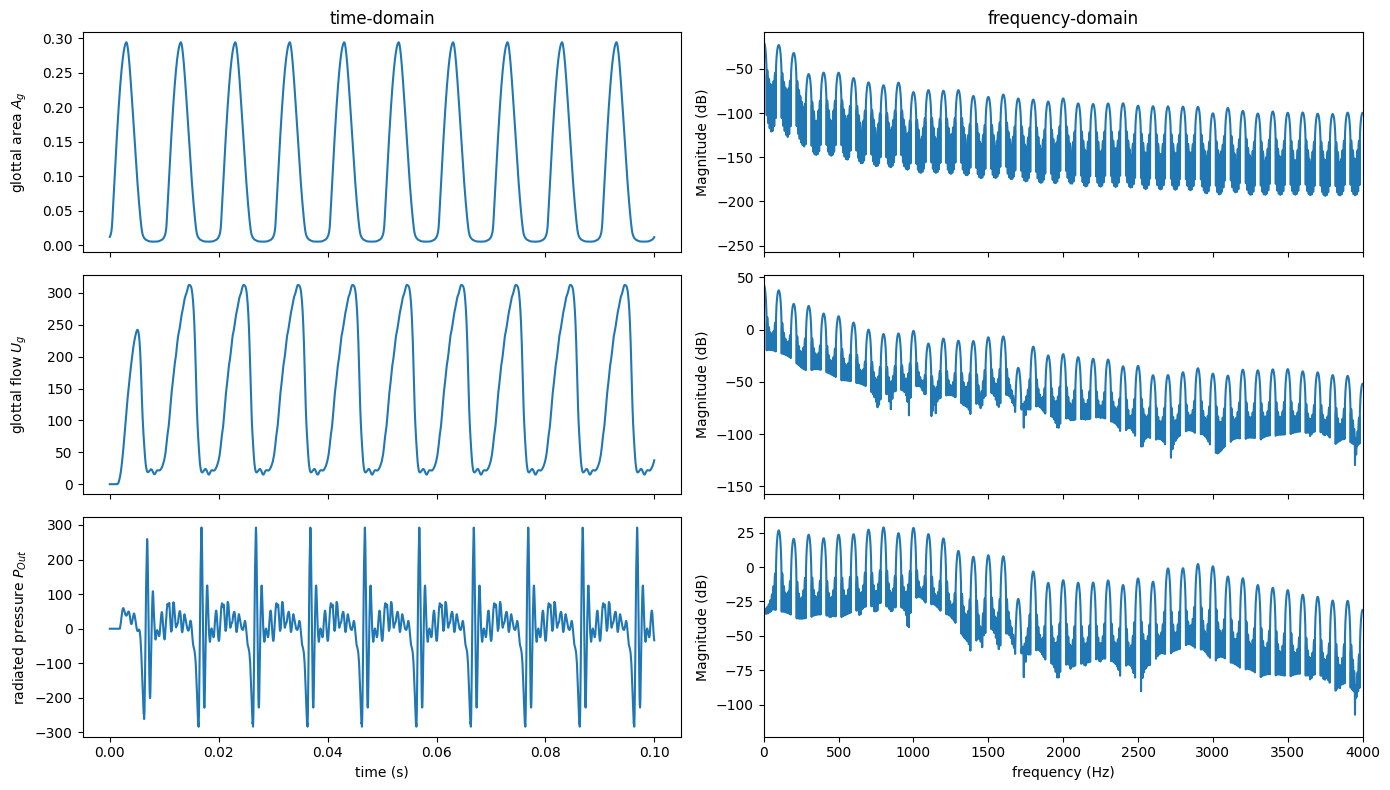

In [6]:
fig, axes = plt.subplots(3, 2, sharex="col", figsize=[14, 8])

for label, x, (tax, fax) in zip(
    ("glottal area $A_g$", "glottal flow $U_g$", "radiated pressure $P_{Out}$"),
    (ga, ug, pout),
    axes,
):
    tax.plot(t, x)
    tax.set_ylabel(label)
    fax.magnitude_spectrum(x, Fs=lt.fs, pad_to=lt.fs, scale="dB")
    fax.set_xlabel("") # remove automatically inserted x-axis labels

axes[0, 0].set_title("time-domain")
axes[0, 1].set_title("frequency-domain")
axes[-1, 0].set_xlabel("time (s)")
axes[-1, 1].set_xlim((0, 4000))
axes[-1, 1].set_xlabel("frequency (Hz)")
fig.align_ylabels(axes[:, 0])
plt.tight_layout() # useful function to automatically adjust the axes margins

Finally, you can use [plt.savefig()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html#matplotlib.pyplot.savefig) to save the last figure as an image or `fig.savefig()` to specify a specific figure object. To save the above figure as `my_pyLeTalker_plot.png`, you need to run the following code:

```python
plt.savefig('my_pyLeTalker_plot.png')
```

## Plotting spectrogram

Spectrogram is an important signal visualization to illustrate the spectro-temporal behavior. For this, we can use [plt.specgram()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html).

To make the spectrogram a bit more interesting, let's run another simulation with a 1-second duration and design an $f_o$ contour with [lt.Interpolator](../api_basic.rst#letalker.Interpolator).

In [7]:
T = 1
N = round(T * lt.fs)

fo = lt.Interpolator([0, 0.3, 0.5, 0.8, 1.0], [100, 90, 85, 110, 120])
pout1, res1 = lt.sim_kinematic(N, fo, "aa")

The default configuration (i.e., `plt.specgram(pout1, NFFT=nseg, Fs=lt.fs)`) is unfit to inspect the vocal behavior. For a better outcome, we need to set three additional critical arguments: `NFFT`, `noverlap`, and `pad_to`. Specifically, we aimed to evaluate spectrum with a 100-milliseond sliding window, which is captured every 10 millisecond. The spectrum is calculated with frequency sample resolution of 1 Hz.

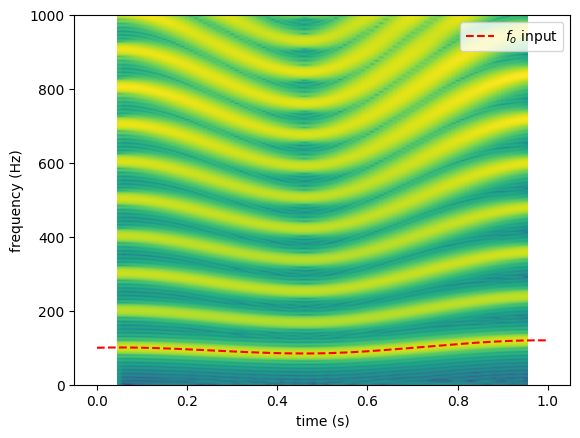

In [8]:
nseg = round(0.1 * lt.fs) # 100 ms in the number of samples
noverlap = round(0.09 * lt.fs) # 10 ms offset to the number of samples overlapped
nfft = lt.fs # sampling rate = 

plt.specgram(pout1, NFFT=nseg, Fs=lt.fs, pad_to=nfft, noverlap=noverlap)
plt.plot(fo.ts(N), fo(N), "r--", label='$f_o$ input') # superimpose fo
plt.ylim([0, 1000])
plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.legend();

Note that the spectrogram is aligned to the center of the sliding window, thus it spans from $t=$ 0.05 to 0.95 second. Meanwhile, the interpolated $f_o$ input spans from 0 to 1 second.